In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.preprocessing import *
import os
from keras.layers.normalization import *

import glob
from keras.applications.vgg16 import preprocess_input 

import cv2
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.optimizers import *
from keras.callbacks import *
from keras.utils import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Data'))

['train', 'validation', 'test']


In [ ]:
data_set=Path('/content/drive/MyDrive/Colab Notebooks/Data')
train_data=data_set/'/content/drive/MyDrive/Colab Notebooks/Data/train'
valid_data=data_set /'/content/drive/MyDrive/Colab Notebooks/Data/validation'
test_data=data_set /'/content/drive/MyDrive/Colab Notebooks/Data/test'

In [ ]:
def load_train():

  normal_case_dir=train_data/'/content/drive/MyDrive/Colab Notebooks/Data/train/NORMAL'
  pneu_case_dir=train_data/'/content/drive/MyDrive/Colab Notebooks/Data/train/PNEUMONIA'
  normal_case=normal_case_dir.glob('*.jpg')
  pneu_case=pneu_case_dir.glob('*.jpg')
  train_da=[]
  label_data=[]

  for img in normal_case:
    train_da.append(img)
    label_data.append("Normal")
  for img in pneu_case:
    train_da.append(img)
    label_data.append("Pneumonia")




  df=pd.DataFrame(train_da,columns=range(1))
  df.columns=['images']
  df['labels']=label_data
  df=df.sample(frac=1).reset_index(drop=True)
  return df



In [ ]:
train_da=load_train()
train_da.shape

(4584, 2)

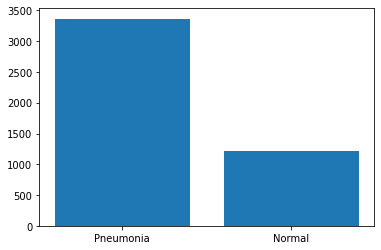

In [ ]:
plt.bar(train_da['labels'].value_counts().index , train_da['labels'].value_counts().values)
plt.show()

In [ ]:
def plot(image,label):
  plt.figure(figsize=(10,5))
  for i in range(10):
    ax=plt.subplot(2,5,i+1)
    img=cv2.imread(str(image[i]))
    img=cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.title(label[i])
    plt.axis("off")




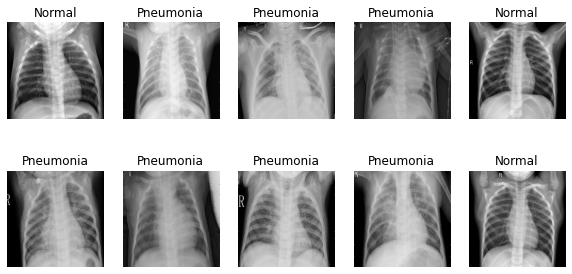

In [ ]:
plot(train_da['images'],train_da["labels"])

In [ ]:
def prepare_and_load(isval=True):
  if isval==True:
    normal_dir=valid_data /'/content/drive/MyDrive/Colab Notebooks/Data/validation/NORMAL'
    pnew_dir=valid_data/'/content/drive/MyDrive/Colab Notebooks/Data/validation/PNEUMONIA'
  else:
     normal_dir=test_data /'/content/drive/MyDrive/Colab Notebooks/Data/test/NORMAL'
     pnew_dir=test_data/'/content/drive/MyDrive/Colab Notebooks/Data/test/PNEUMONIA'
  normal_case=normal_dir.glob("*.jpg")
  pnew_case=pnew_dir.glob('*.jpg') #file and folder ar value return kore jader same pattern 
  data,labels=([] for x in range(2))#array
  def prepare(case):
    for img in case:
      img=cv2.imread(str(img))
      img=cv2.resize(img,(224,224))
      if img.shape[2]==1:
        img=np.dstack([img,img,img])#vartically image ghula process hosse
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#img ghula k RGB te covert korlam
      img=img.astype(np.float32)/255 #normalized korlam
      if case==normal_case:

        label=to_categorical(0,num_classes=2)
      else:
        label=to_categorical(1,num_classes=2)

        data.append(img)
        labels.append(label)
    return data,labels
  prepare(normal_case)
  d,l=prepare(pnew_case)
  d=np.array(d)
  l=np.array(l)
  return d,l








In [ ]:
v_data,v_labels=prepare_and_load(isval=True)
test_data,test_labels = prepare_and_load(isval=False)
print('Number of Test Images: ',len(test_data))
print('Number of Validation Images: ',len(v_data))

Number of Test Images:  783
Number of Validation Images:  144


In [ ]:
def data_gen(data,batch_size):
    #get total Number of sample in data
    n = len(data)
    steps =n//batch_size
    #define two numpty arrays for containg batch & labeol data
    batch_data = np.zeros((batch_size,224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size,2),dtype=np.float32)

    #get a numpty aray 
    indices = np.arange(n)
    i = 0
    while True:
        np.random.shuffle(indices)
        #Shuffling means changing the position of the elements of the sequence.
        # Here, the shuffling operation is inplace.
        #get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i-1)*batch_size]
        for j,idx in enumerate(next_batch):
          # Enumerate() method adds a counter to 
          #an iterable and returns it in a form of enumerating object.
          #converted into a list of tuples using the list() method.

            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='Normal':
                label=0
            else:
                label=1

            #one hot encoding that means 0,1 convert korbo
            encoded_label = to_categorical(label,num_classes=2)
            #num_classes means totall number of classes
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))

            #check if its shape is grayscale
            if img.shape[2]==1:
                img = np.dstack([img,img,img])
            #convert color
            orig_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #NORMALIZE the image pixels 
            orig_img = img.astype(np.float32)/255
            batch_data[count]=orig_img
            batch_labels[count]=encoded_label
            count = count +1

            if count==batch_size-1:
              break
        i += 1
        yield batch_data,batch_labels
        #Yield is a keyword in Python that is used to return from a function 
        #without destroying the states of its local
         #variable and when the function is called, the execution starts from
          #the last yield statement. 
        if i>=steps:
          i=0


In [ ]:
model=Sequential()
#keras sequential which deals with ordering or sequencing of layers within a model.
#that means sequentially data k sajai..
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
#relu :if negative value throug the model relu funtion return 0,
#if positive value dewa hoii relu function ta oi  positive value tai return kore
model.add(MaxPooling2D(pool_size=(2,2)))
#matrices ar modde max value ta niya kaj kore

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
 #convert to 1 dimensions.that means creat a model for output

model.add(Dense(64))
#dense layer ta deeply connected layer ,you can call hidden layer
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax')) 
#softmax is activation function for two features 


In [ ]:
batch_size = 20
nb_epochs = 7

#Get trian data genrator
train_data_gen= data_gen(data=train_da,batch_size=batch_size)

#Define number of traing steps
nb_train_steps = train_da.shape[0]//batch_size

print('number of training a validation steps: {} and {}'.format(nb_train_steps,len(v_data)))

number of training a validation steps: 229 and 144


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,validation_data=(v_data, v_labels))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/7
229/229 [==============================] - 18s 30ms/step - loss: 0.0321 - accuracy: 0.9710 - val_loss: 0.2988 - val_accuracy: 0.9444
Epoch 2/7
229/229 [==============================] - 17s 28ms/step - loss: 0.0960 - accuracy: 0.9886 - val_loss: 0.4423 - val_accuracy: 0.9583
Epoch 3/7
229/229 [==============================] - 18s 28ms/step - loss: 0.2787 - accuracy: 0.9334 - val_loss: 1.8118 - val_accuracy: 0.7917
Epoch 4/7
229/229 [==============================] - 18s 28ms/step - loss: 0.0765 - accuracy: 0.9465 - val_loss: 0.4474 - val_accuracy: 0.9583
Epoch 5/7
229/229 [==============================] - 19s 28ms/step - loss: 0.4649 - accuracy: 0.9371 - val_loss: 1.1393 - val_accuracy: 0.7986
Epoch 6/7
229/229 [==============================] - 17s 27ms/step - loss: 0.0286 - accuracy: 0.9469 - val_loss: 1.2213 - val_accuracy: 0.8819
Epoch 7/7
229/229 [==============================] - 22s 28ms/step - loss: 0.1189 - accuracy: 0.9367 - val_loss: 0.7884 - val_accuracy: 0.8681

In [ ]:
# VGG16 is an efficient deep learning model for image classification with 16 layers.
# The model is also widely used as an image-feature extractor in a transfer learning
#
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    
    x = Dense(1024,activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)#dropout ta kora hoi mainly overfitting komanor jonno
    x = Dense(2,activation='softmax')(x)
   # model = Model(input=input, output=x)
    model = tf.keras.Model(model.input, outputs=x)
    #return model
    return model

In [ ]:

vgg_conv = vgg16_model(2)
for y in vgg_conv.layers[:-10]:
   y.trainable = False
  


553476096/553467096 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001,decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,
                            validation_data=(v_data,v_labels),class_weight={0:1.0,1:0.4})

Epoch 1/7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


229/229 [==============================] - 20s 87ms/step - loss: 0.1290 - accuracy: 0.9692 - val_loss: 18.4454 - val_accuracy: 0.0000e+00
Epoch 2/7
229/229 [==============================] - 18s 80ms/step - loss: 0.0249 - accuracy: 0.9631 - val_loss: 40.0016 - val_accuracy: 0.0000e+00
Epoch 3/7
229/229 [==============================] - 22s 96ms/step - loss: 0.0589 - accuracy: 0.9459 - val_loss: 12.9722 - val_accuracy: 0.0486
Epoch 4/7
229/229 [==============================] - 17s 76ms/step - loss: 0.0541 - accuracy: 0.9428 - val_loss: 41.7386 - val_accuracy: 0.0000e+00
Epoch 5/7
229/229 [==============================] - 21s 92ms/step - loss: 0.0672 - accuracy: 0.9913 - val_loss: 16.5519 - val_accuracy: 0.0000e+00
Epoch 6/7
229/229 [==============================] - 18s 77ms/step - loss: 0.0645 - accuracy: 0.9421 - val_loss: 11.0589 - val_accuracy: 0.0347
Epoch 7/7
229/229 [==============================] - 18s 80ms/step - loss: 0.0134 - accuracy: 0.9467 - val_loss: 6.8959 - val_accu

In [ ]:
#get pridictions
pred=vgg_conv.predict(test_data,batch_size=12)
pred=np.argmax(pred,axis=-1)
#original labels
labels=np.argmax(test_labels,axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.06      0.11       783

    accuracy                           0.06       783
   macro avg       0.50      0.03      0.05       783
weighted avg       1.00      0.06      0.11       783



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
